<a href="https://colab.research.google.com/github/YounSooKimTech/Joy_NLP_Power/blob/main/202309_NLP_Poster_Statistical_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess the Enron Corpus

In [159]:
# Enron Dataset
# preprocessed Enrone dataset

import pandas as pd

emails = pd.read_csv("https://raw.githubusercontent.com/YounSooKimTech/Joy_NLP_Power/main/data/Enron_merged_df.csv")

emails["rank_diff"] = emails["Sender_Rank"] - emails["Receiver_Rank"]

# subset of the dataset which is needed for the research
s_emails = emails[["direction", "content", "rank_diff"]]
s_emails = s_emails.fillna('')

s_emails.head()

,direction,content,rank_diff
0,same,,0
1,same,,0
2,same,,0
3,downward,i cant open this,1
4,downward,,1


In [160]:
name_list_receiver = set(emails["Receiver_Name"].str.split().explode().str.lower())
name_list_sender = set(emails["Sender_Name"].str.split().explode().str.lower())

name_list = list(name_list_receiver | name_list_sender)

In [161]:
import spacy
nlp = spacy.load("en_core_web_sm")
default_stop_words = spacy.lang.en.stop_words.STOP_WORDS

custom_stop_words = default_stop_words - {
    "can", "could", "may", "might", "shall", "should", "will", "would", "must", "ought"
}

print(default_stop_words)
print(custom_stop_words)

{'whole', 'if', 'seemed', 'everything', 'wherein', 'whence', 'above', 'themselves', 'such', 'eleven', 'various', 'he', 'should', 'well', "'m", 'yourself', 'either', 'show', 'sometime', 'could', 'just', 'beforehand', 'onto', 'n’t', 'anyone', 'some', 'go', 'thence', 'was', 'this', 'us', 'without', 'keep', 'though', 'himself', 'me', 'up', 'nothing', 'during', 'whatever', 'meanwhile', 'everywhere', 'thereby', 'therein', 'thru', 'whereafter', 'per', 'hers', 'get', 'down', 'therefore', 'its', 'their', 'your', 'and', 'sixty', 'make', 'am', 'is', 'because', 'where', 'might', 'whose', 'unless', 'whenever', 'to', 'too', 'thus', 'whither', 'third', 'about', 'what', 'sometimes', 'until', 'more', 'made', 'anywhere', 'also', 'formerly', 'here', 'but', 'together', 'part', 'hence', 'now', 'how', 'former', 'further', 'hereby', 'nine', 'several', 'enough', 'under', 'somewhere', 'did', 'six', 'moreover', 'twenty', 'below', 'mine', 'then', 'give', 'twelve', 'amount', 'seeming', 'call', 'wherever', 'she', 

In [163]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")
custom_remove_words = {"na", "cc", '`', "+"}

def lemmatize_text_and_remove_punct(text):
    doc = nlp(text)
    date_pattern = re.compile(r'\d{1,2}/\d{1,2}/\d{2,4}')
    time_pattern = re.compile(r'\d{1,2}:\d{2}(:\d{2})?$')

    tokens = [token.lemma_.lower() for token in doc if
                         not token.is_punct
                         and token if not token.like_num
                         and not date_pattern.match(token.text)
                         and not time_pattern.match(token.text)
                         and "@" not in token.text
                         and "$" not in token.text
                         and "=" not in token.text
                         and token.text.lower() not in custom_stop_words
                         and token.text.lower() not in custom_remove_words
                         and token.text.lower() not in name_list
                         and token.ent_type_ != "PERSON"
                         and token.ent_type_ != "DATE"
                         and token.ent_type_ != "TIME"
                         and len(token.lemma_) >= 3
                         ]
    tokens = [token for token in tokens if token.strip()]
    return tokens

# Apply the lemmatize_text_and_remove_punct function to the "content" column and store the result in a new column
s_emails["tokens"] = s_emails["content"].apply(lemmatize_text_and_remove_punct)

In [164]:
s_emails["unique_tokens"] = s_emails["tokens"].apply(set)
s_emails["n_tokens"] = s_emails["tokens"].apply(len)
s_emails["n_unique_tokens"] = s_emails["unique_tokens"].apply(len)

In [165]:
import numpy as np
from scipy import stats

s_emails["n_unique_tokens"].fillna(0, inplace=True)

s_emails["token_z_scores"] = stats.zscore(s_emails["n_unique_tokens"])

s_emails_no_outliers = s_emails[(s_emails["token_z_scores"]<3) & (s_emails["token_z_scores"]>-3)]

print(s_emails.shape, s_emails_no_outliers.shape)

(2021, 8) (1997, 8)


In [33]:
s_emails["unique_tokens"].explode().unique()

unique_tokens = s_emails["unique_tokens"].explode().unique()

batch_size = 20

'''
# Iterate over the unique tokens in batches
for i in range(0, len(unique_tokens), batch_size):
    batch = unique_tokens[i:i+batch_size]
    print(batch)
'''

'\n# Iterate over the unique tokens in batches\nfor i in range(0, len(unique_tokens), batch_size):\n    batch = unique_tokens[i:i+batch_size]\n    print(batch)\n'

# Statistical Test for the n_unique_tokens

In [166]:
# ANOVA and TukeyHSD result

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ANOVA
model = ols('n_unique_tokens ~ C(direction)', data=s_emails_no_outliers).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print("\n\n")

# perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(s_emails_no_outliers["n_unique_tokens"], s_emails_no_outliers['direction'])
print(tukey_results)
print("\n")

# Print the p-values
print(f"Tukey's HSD P-Values: {[round(p, 5) for p in tukey_results.pvalues]}")


                     sum_sq      df         F    PR(>F)
C(direction)    4539.814649     2.0  12.74638  0.000003
Residual      355096.530869  1994.0       NaN       NaN



Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower  upper  reject
----------------------------------------------------
downward   same   0.0041   1.0 -1.6825 1.6907  False
downward upward   3.2741   0.0  1.5031 5.0452   True
    same upward   3.2701   0.0  1.5628 4.9773   True
----------------------------------------------------


Tukey's HSD P-Values: [0.99998, 5e-05, 2e-05]


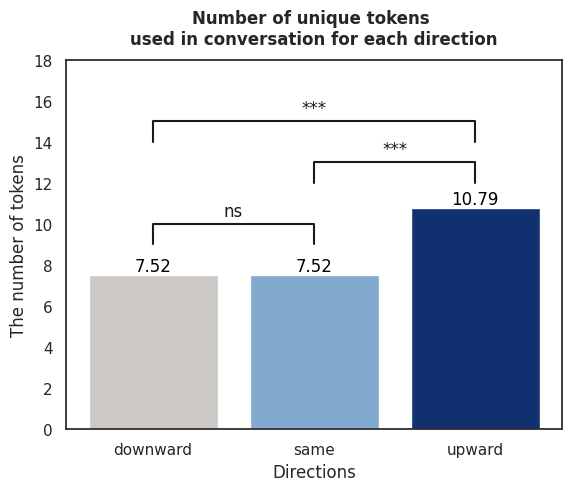

In [200]:
# visualize the pairwise comparison results

import matplotlib.pyplot as plt
import seaborn as sns

data = s_emails_no_outliers

# Create your plot with Seaborn
order = ["downward", "same", "upward"]

rgb = [(205, 201, 197), (117, 170, 219), (0, 43, 127)]
colors = [tuple(t / 255 for t in x) for x in rgb]



ax0 = sns.barplot(
    data=data,
    x="direction",
    y="n_unique_tokens",
    order=order,
    palette=colors,
    errorbar=None,
)

# Increase white space at the top of the plot by setting the y-axis limits
plt.ylim(0, 18)

h = 1

# text for first[0] and second[1] bar in the graph
y_01 = 9
plt.plot([0, 0, 1, 1], [y_01, y_01 + h, y_01 + h, y_01], lw=1.5, c=col)
plt.text((0 + 1) * 0.5, y_01 + h*1.2, "ns", ha='center', va='bottom', color=col)

# text for same[0] and upward[2] bar in the graph
y_12 = 12
plt.plot([1, 1, 2, 2], [y_12, y_12 + h, y_12 + h, y_12], lw=1.5, c=col)
plt.text((1 + 2) * 0.5, y_12 + h*1.2, "***", ha='center', va='bottom', color=col)

# text for down[0] and upward[2] bar in the graph
y_02 = 14
plt.plot([0, 0, 2, 2], [y_02, y_02 + h, y_02 + h, y_02], lw=1.5, c=col)
plt.text((0 + 2) * 0.5, y_02 + h*1.2, "***", ha='center', va='bottom', color=col)


# mark the number
for p in ax0.patches:
    ax0.annotate(f"{p.get_height():.2f}",  # Format the mean value to 2 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the text
                ha='center', va='bottom', fontsize=12, color='black')


# Show the plot
plt.title("Number of unique tokens \nused in conversation for each direction", fontweight="bold", y= 1.02)
plt.xlabel("Directions")
plt.ylabel("The number of tokens")
plt.show()


# Conc scores

In [174]:
# concreteness word dictionary

import pandas as pd

# use unigram ones
dic_con = pd.read_csv('https://raw.githubusercontent.com/YounSooKimTech/Joy_NLP_Power/main/data/Dic_Concretness.csv')
dict_conc = dic_con
# dict_conc = dic_con[dic_con.Bigram == 0][["Word", "Conc.M"]]

# use the average scores as scoring for the Corpus
# make all the words as lower
df_scores = dict_conc
df_scores = df_scores.rename(columns = {"Word":"word", "Conc.M":"score"})
df_scores["word"] = df_scores["word"].str.lower()

df_scores.head(2)

,word,Bigram,score,Conc.SD,Unknown,Total,Percent_known,SUBTLEX
0,a,0,1.46,1.14,2,30,0.93,1041179
1,aardvark,0,4.68,0.86,0,28,1.00,21


In [175]:
def calculate_sum(word_list):
    relevant_scores = df_scores[df_scores['word'].isin(word_list)]['score']
    return relevant_scores.sum()

def calculate_average_score(word_list):
    relevant_scores = df_scores[df_scores['word'].isin(word_list)]['score']
    return relevant_scores.mean()

s_emails_no_outliers["token_total_score"] = s_emails_no_outliers["unique_tokens"].apply(calculate_sum)
s_emails_no_outliers["token_avg_score"] = s_emails_no_outliers["unique_tokens"].apply(calculate_average_score)
s_emails_no_outliers["token_avg_score"].fillna(0, inplace=True)


<ipython-input-175-411b2842a179>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_emails_no_outliers["token_total_score"] = s_emails_no_outliers["unique_tokens"].apply(calculate_sum)
<ipython-input-175-411b2842a179>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_emails_no_outliers["token_avg_score"] = s_emails_no_outliers["unique_tokens"].apply(calculate_average_score)
<ipython-input-175-411b2842a179>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

In [177]:
s_emails_no_outliers.head(5)

,direction,content,rank_diff,tokens,unique_tokens,n_tokens,n_unique_tokens,token_z_scores,token_total_score,token_avg_score
0,same,,0,[],{},0,0,-0.401003,0.00,0.000
1,same,,0,[],{},0,0,-0.401003,0.00,0.000
2,same,,0,[],{},0,0,-0.401003,0.00,0.000
3,downward,i cant open this,1,"[not, open]","{not, open}",2,2,-0.323790,5.29,2.645
4,downward,,1,[],{},0,0,-0.401003,0.00,0.000


In [178]:
# ANOVA and TukeyHSD result

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ANOVA
model = ols('token_avg_score ~ C(direction)', data=s_emails_no_outliers).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print("\n\n")

# perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(s_emails_no_outliers["token_avg_score"], s_emails_no_outliers['direction'])
print(tukey_results)
print("\n")

# Print the p-values
print(f"Tukey's HSD P-Values: {[round(p, 5) for p in tukey_results.pvalues]}")

                   sum_sq      df          F        PR(>F)
C(direction)    99.732539     2.0  24.847508  2.193516e-11
Residual      4001.742970  1994.0        NaN           NaN



 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
downward   same  -0.3403    0.0 -0.5194 -0.1613   True
downward upward   0.1922 0.0437  0.0042  0.3802   True
    same upward   0.5326    0.0  0.3513  0.7138   True
------------------------------------------------------


Tukey's HSD P-Values: [3e-05, 0.04372, 0.0]


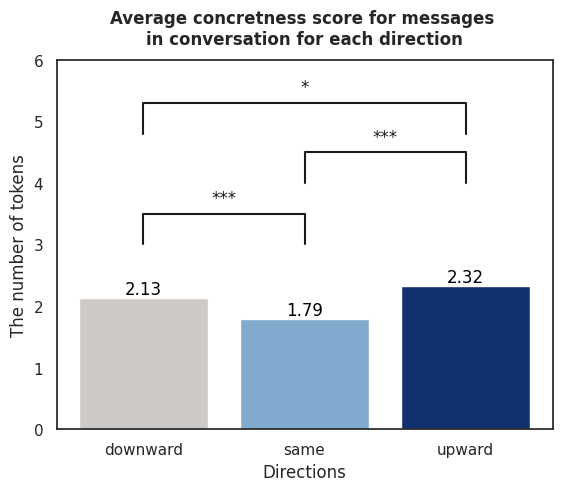

In [201]:
# visualize the pairwise comparison results

import matplotlib.pyplot as plt
import seaborn as sns

data = s_emails_no_outliers

# Create your plot with Seaborn
order = ["downward", "same", "upward"]
colors = [tuple(t / 255 for t in x) for x in rgb]


ax1 = sns.barplot(
    data=data,
    x="direction",
    y="token_avg_score",
    order=order,
    errorbar=None,
    palette=colors,
)

# Increase white space at the top of the plot by setting the y-axis limits
plt.ylim(0, 6)

h = 0.5

# text for down[0] and same[1] bar in the graph
y_01 = 3
plt.plot([0, 0, 1, 1], [y_01, y_01 + h, y_01 + h, y_01], lw=1.5, c=col)
plt.text((0 + 1) * 0.5, y_01 + h*1.2, "***", ha='center', va='bottom', color=col)

# text for same[1] and upward[2] bar in the graph
y_12 = 4
plt.plot([1, 1, 2, 2], [y_12, y_12 + h, y_12 + h, y_12], lw=1.5, c=col)
plt.text((1 + 2) * 0.5, y_12 + h*1.2, "***", ha='center', va='bottom', color=col)

# text for down[0] and upward[2] bar in the graph
y_02 = 4.8
plt.plot([0, 0, 2, 2], [y_02, y_02 + h, y_02 + h, y_02], lw=1.5, c=col)
plt.text((0 + 2) * 0.5, y_02 + h*1.2, "*", ha='center', va='bottom', color=col)

# mark the number
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.2f}",  # Format the mean value to 2 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the text
                ha='center', va='bottom', fontsize=12, color='black')


# Show the plot
plt.title("Average concretness score for messages \nin conversation for each direction", fontweight="bold", y= 1.02)
plt.xlabel("Directions")
plt.ylabel("The number of tokens")
plt.show()


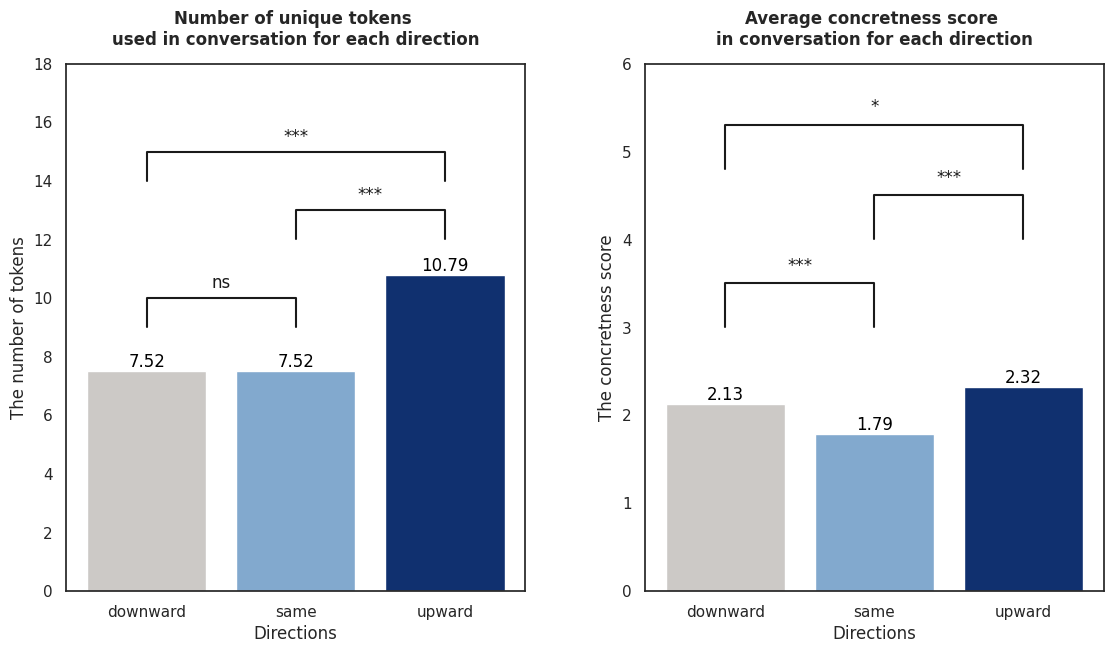

In [227]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
plt.subplots_adjust(wspace=8000)


#####################################################################
data = s_emails_no_outliers
order = ["downward", "same", "upward"]
rgb = [(205, 201, 197), (117, 170, 219), (0, 43, 127)]
colors = [tuple(t / 255 for t in x) for x in rgb]


sns.barplot(
    data=data,
    x="direction",
    y="n_unique_tokens",
    order=order,
    palette=colors,
    errorbar=None,
    ax = ax0,
)

# Increase white space at the top of the plot by setting the y-axis limits
ax0.set_ylim(0, 18)

h = 1

# text for first[0] and second[1] bar in the graph
y_01 = 9
ax0.plot([0, 0, 1, 1], [y_01, y_01 + h, y_01 + h, y_01], lw=1.5, c=col)
ax0.text((0 + 1) * 0.5, y_01 + h*1.2, "ns", ha='center', va='bottom', color=col)

# text for same[0] and upward[2] bar in the graph
y_12 = 12
ax0.plot([1, 1, 2, 2], [y_12, y_12 + h, y_12 + h, y_12], lw=1.5, c=col)
ax0.text((1 + 2) * 0.5, y_12 + h*1.2, "***", ha='center', va='bottom', color=col)

# text for down[0] and upward[2] bar in the graph
y_02 = 14
ax0.plot([0, 0, 2, 2], [y_02, y_02 + h, y_02 + h, y_02], lw=1.5, c=col)
ax0.text((0 + 2) * 0.5, y_02 + h*1.2, "***", ha='center', va='bottom', color=col)


# mark the number
for p in ax0.patches:
    ax0.annotate(f"{p.get_height():.2f}",  # Format the mean value to 2 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the text
                ha='center', va='bottom', fontsize=12, color='black')


# Show the plot
ax0.set_title("Number of unique tokens \nused in conversation for each direction", fontweight="bold", y= 1.02)
ax0.set_xlabel("Directions")
ax0.set_ylabel("The number of tokens")



######################################################

sns.barplot(
    data=data,
    x="direction",
    y="token_avg_score",
    order=order,
    errorbar=None,
    palette=colors,
    ax = ax1,
)

# Increase white space at the top of the plot by setting the y-axis limits
ax1.set_ylim(0, 6)

h = 0.5

# text for down[0] and same[1] bar in the graph
y_01 = 3
ax1.plot([0, 0, 1, 1], [y_01, y_01 + h, y_01 + h, y_01], lw=1.5, c=col)
ax1.text((0 + 1) * 0.5, y_01 + h*1.2, "***", ha='center', va='bottom', color=col)

# text for same[1] and upward[2] bar in the graph
y_12 = 4
ax1.plot([1, 1, 2, 2], [y_12, y_12 + h, y_12 + h, y_12], lw=1.5, c=col)
ax1.text((1 + 2) * 0.5, y_12 + h*1.2, "***", ha='center', va='bottom', color=col)

# text for down[0] and upward[2] bar in the graph
y_02 = 4.8
ax1.plot([0, 0, 2, 2], [y_02, y_02 + h, y_02 + h, y_02], lw=1.5, c=col)
ax1.text((0 + 2) * 0.5, y_02 + h*1.2, "*", ha='center', va='bottom', color=col)

# mark the number
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.2f}",  # Format the mean value to 2 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the text
                ha='center', va='bottom', fontsize=12, color='black')


# Show the plot
ax1.set_title("Average concretness score \nin conversation for each direction", fontweight="bold", y= 1.02)
ax1.set_xlabel("Directions")
ax1.set_ylabel("The concretness score")

plt.tight_layout(pad=2)
plt.show()

# ETC
I have a dream to use statannot library for the graph


In [56]:
! pip install statannot

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

downward v.s. same: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-4.222e-02
same v.s. upward: t-test independent samples with Bonferroni correction, P_val=5.519e-05 stat=-4.299e+00
downward v.s. upward: t-test independent samples with Bonferroni correction, P_val=2.646e-05 stat=-4.463e+00


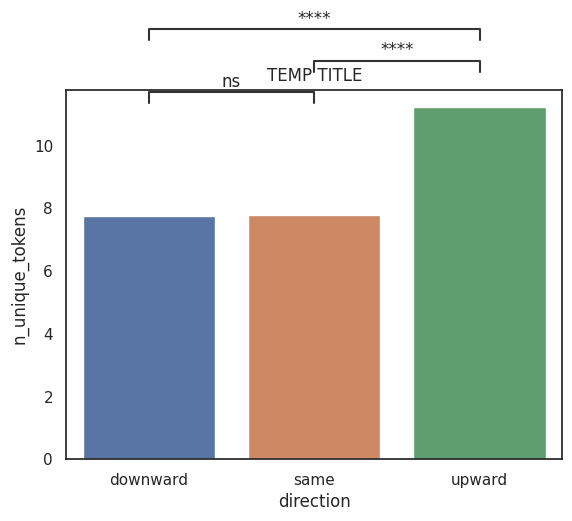

In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statannot

sns.set(style="white")
data = s_emails_no_outliers

# Create your plot with Seaborn
order = ["downward", "same", "upward"]

ax = sns.barplot(
    data=data,
    x="direction",
    y="n_unique_tokens",
    order=order,
    errorbar = None,
)

# Define the pairs of bars/groups you want to compare
box_pairs = [("downward", "same"), ("downward", "upward"), ("same", "upward")]

# Add statistical annotations to the plot
statannot.add_stat_annotation(
    ax=ax,
    data=data,
    x="direction",
    y="n_unique_tokens",
    order=order,
    box_pairs=box_pairs,
    test="t-test_ind",  # You can adjust the test as needed
    text_format="star",
    loc="outside",
    line_height=0.03,
    verbose=True,
    #line_offset_to_box=0.0,
    #line_offset = 0,
)

# Show the plot
plt.title("TEMP TITLE")
plt.show()


In [ ]:
x_pos = order.index("same") + 0.5  # Position it in the middle of "same"
plt.annotate("*", xy=(x_pos, 15), ha="center", fontsize=12)

x_pos = order.index("same") + 0.5  # Position it in the middle of "same"
plt.axhline(y=18, linestyle='--', color='red', lw=2)


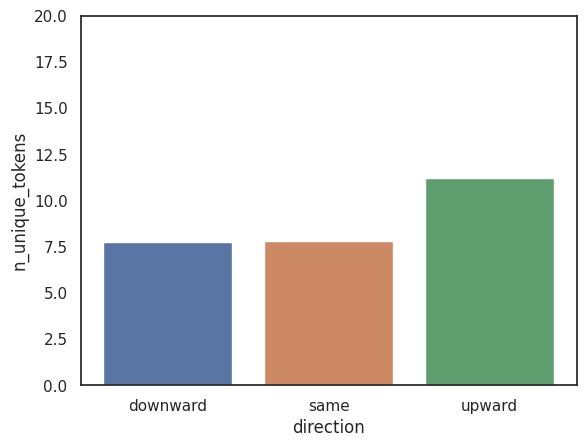

In [110]:
order = ["downward", "same", "upward"]

sns.barplot(
    data=data,
    x="direction",
    y="n_unique_tokens",
    order=order,
    errorbar = None,
)

plt.ylim(0,20)


x1, x2 =1 , 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = s_emails_no_outliers["n_unique_tokens"].max() + 2, 2, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

plt.show()


                     sum_sq      df          F    PR(>F)
C(direction)    5021.823524     2.0  13.125719  0.000002
Residual      381637.671971  1995.0        NaN       NaN



 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
downward   same   0.0299 0.9991 -1.7181  1.778  False
downward upward   3.4553    0.0  1.6206 5.2901   True
    same upward   3.4254    0.0  1.6567 5.1941   True
-----------------------------------------------------





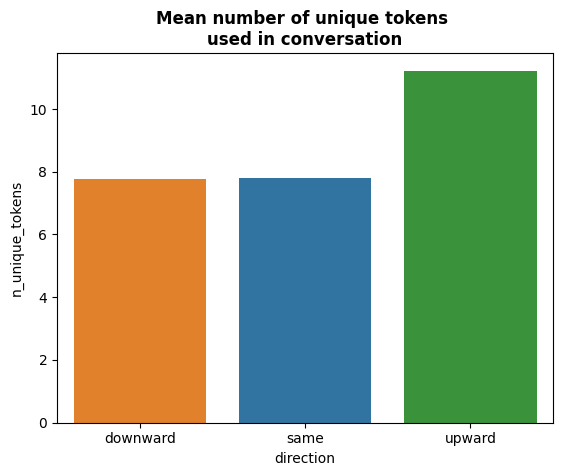

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04



TypeError: ignored

<Figure size 640x480 with 0 Axes>

In [48]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ANOVA
model = ols('n_unique_tokens ~ C(direction)', data=s_emails_no_outliers).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print("\n\n")

# perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(s_emails_no_outliers["n_unique_tokens"], s_emails_no_outliers['direction'])
print(tukey_results)
print("\n\n")

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

order = ["downward", "same", "upward"]
ax = sns.barplot(data=s_emails_no_outliers,
            x = "direction",
            y="n_unique_tokens",
            hue = "direction",
            estimator = "mean",
            errorbar = None,
            dodge=False,
             order = order)

#plt.subplots_adjust(top=2)
#plt.ylim(top=15)
plt.legend([],[], frameon=False)

plt.title("Mean number of unique tokens \nused in conversation", fontweight = "bold")
plt.show()

pairs = [("downward", "same"), ("same", "upward"), ("downward", "same")]

import statannot
statannot.add_stat_annotation(
    ax=ax,
    data=s_emails_no_outliers,
    x="direction",
    y="n_unique_tokens",
    hue="direction",
    test="t-test_ind",
    text_format="star",
    loc="outside",
    verbose=2,  # Optional: Increase verbosity to see test results
    comparisons_correction=None,  # Optional: Correction method for multiple comparisons
    line_height=0.03,  # Optional: Adjust the vertical position of the annotations
    order=order,  # Specify the order of categories
)


In [ ]:
# import matplotlib.pyplot as plt
# means =s_emails.groupby('direction')['n_unique_tokens'].mean()
# plt.bar(means.index, means.values)
